In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
import statsmodels.api as sm
import scipy.stats as stats
import cartopy.crs as ccrs
import pygrib
import cfgrib
import glob

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)



In [2]:
class Data():
    def get_eps_data(experiments, inidate='2022-02-16'):
        """
        Function to load comlete data of simulations on surface level since
        xr has a bug that prevents using
        this as a simpler solution

        Input:
        ------
        experiments: list of strings, list of experiments to import,
                e.g. ['pi', 'curr', 'incr']

        Output:
        -------
        eps: list of xarrays, data and metadata of operational forecasts,
        each list entry is one experiment
        """

        directory = {'pi': '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/',
                    'curr': '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/',
                    'incr': '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/'}

        eps = {}
        for experiment in experiments:
            exp_eps = []
            for c, cont in enumerate(['cf', 'pf']):
                for files in glob.glob(directory[experiment]
                                        + cont + '/*'
                                        + inidate + '*.nc'):
                    print(files)
                    data = xr.open_dataset(files)
                    exp_eps.append(Data.preproc_ds(data.get(['fg10', 'msl',
                                                                'u10', 'v10',
                                                                'u100', 'v100'])))

            eps[experiment] = xr.concat(exp_eps, dim='number').squeeze()

        return eps
    

    def preproc_ds(ds):
        """
        Main pre-processing function
        Writtten by Nick Leach.

        Input:
        ------

        Output:
        -------
        """

        # accumulated variables & scaling factors
        accumulated_vars = {'tp': 60 * 60 * 24 * 1e3,
                            'ttr': 1,
                            'tsr': 1,
                            'str': 1,
                            'ssr': 1,
                            'e': 1}
        accumulated_var_newunits = {'tp': 'mm day$^{-1}$',
                                    'ttr': 'W m$^{-2}$',
                                    'tsr': 'W m$^{-2}$',
                                    'str': 'W m$^{-2}$',
                                    'ssr': 'W m$^{-2}$',
                                    'e': 'm s$^{-1}$'}
        ds = ds.copy().squeeze()
        # set up aux data
        inidate = pd.to_datetime(ds.time[0].values)
        # expand dimensions to include extra info
        if not 'hDate' in ds:
            ds = ds.expand_dims({'inidate': [inidate]}).copy()

        if not 'number' in ds:
            ds = ds.expand_dims({'number': [0]}).copy()

        # put time dimension at front
        ds = ds.transpose('time', ...)
        ds = ds.copy(deep=True)

        # convert accumulated variables into instantaneous
        for var, sf in accumulated_vars.items():
            if var in ds.keys():
                ds[var].loc[dict(time=ds.time[1:])] = Data.accum2rate(ds[var]) * sf
                # set first value to equal zero,
                # should be zero but isn't always
                ds[var].loc[dict(time=ds.time[0])] = 0
                ds[var].attrs['units'] = accumulated_var_newunits[var]
        return ds

In [3]:
# Load data from MED-R Preindustrial and increased
'''
directory_exp = '/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/'

experiments = ['incr', 'pi']
cfpf = ['cf', 'pf']  # control and perturbed are treated equally
members = {'pi' : ['b2nn_2022-02-14', 'b2ns_2022-02-16', 'b2nq_2022-02-10'], 
           'incr' : ['b2no_2022-02-14', 'b2nr_2022-02-10', 'b2nt_2022-02-16']}  # members for incr and pi runs

wind_gusts_pi = []
wind_gusts_incr = []
'''

#wind_gusts_pi.extend(list(xr.open_dataset(os.path.join(directory_exp,'pi', 'EU025/sfc','cf','b2nn_2022-02-14'+'.nc')).fg10.values.flatten()))

'''
for experiment in experiments:
    for cont in cfpf:
        for member in members[experiment]:
            if experiment == 'pi':
                wind_gusts_pi.extend(list(xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,member+'.nc')).fg10.values.flatten()))
            elif experiment == 'incr':
                wind_gusts_incr.extend(list(xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,member+'.nc')).fg10.values.flatten()))
'''

Data.get_eps_data(['pi'])

"\nfor experiment in experiments:\n    for cont in cfpf:\n        for member in members[experiment]:\n            if experiment == 'pi':\n                wind_gusts_pi.extend(list(xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,member+'.nc')).fg10.values.flatten()))\n            elif experiment == 'incr':\n                wind_gusts_incr.extend(list(xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,member+'.nc')).fg10.values.flatten()))\n"

In [4]:
'''
# Load data from current climate
directory_ens = '/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/'
# dates = ['07', '08', '09', '10', '11', '12', '13', '14', '15', '16']
dates = ['10','14','16']
wind_gusts_curr = []
#wind_gusts_curr.extend(list(xr.open_dataset(os.path.join(directory_ens,'cf','1_2022-02-'+'14'+'.nc')).fg10.values.flatten()))


for cont in cfpf:
    for date in dates:
        wind_gusts_curr.extend(list(xr.open_dataset(os.path.join(directory_ens,cont,'1_2022-02-'+date+'.nc')).fg10.values.flatten()))


'''

"\nfor cont in cfpf:\n    for date in dates:\n        wind_gusts_curr.extend(list(xr.open_dataset(os.path.join(directory_ens,cont,'1_2022-02-'+date+'.nc')).fg10.values.flatten()))\n"

right, the kernel crash here (just above) everytime I ran it.
The code must be working, so it's the environment
1. usually this happened bc of the wrong installment of numpy (according to python)
1.1 reinstalled in conda, didn't work#
2. environment--like ipykernal thingy (jupyter) messing with conda:?
2.1 ha, disabled jupyter and this is still fking there


ValueError: Sample larger than population or is negative

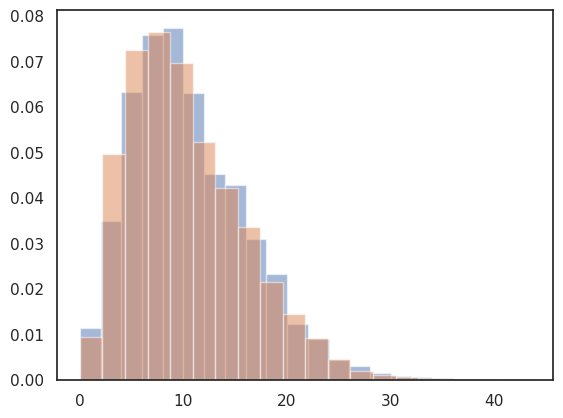

In [5]:
plt.hist(random.sample(wind_gusts_pi, 10000), alpha = 0.5, density = True, bins = 20, label = 'PI')
plt.hist(random.sample(wind_gusts_curr, 10000), alpha = 0.5, density = True, bins = 20, label = 'CURR')
plt.hist(random.sample(wind_gusts_incr, 10000), alpha = 0.5, density = True, bins = 20, label = 'INCR')
plt.xlabel('wind gusts on 10m (m/s)')
plt.ylabel('frequency')
plt.legend()
sns.despine()

plt.hist(random.sample(wind_gusts_pi, 10000), alpha = 0.5, density = True, bins = 20, label = 'PI')
plt.hist(random.sample(wind_gusts_curr, 10000), alpha = 0.5, density = True, bins = 20, label = 'CURR')
plt.hist(random.sample(wind_gusts_incr, 10000), alpha = 0.5, density = True, bins = 20, label = 'INCR')
plt.xlabel('wind gusts on 10m (m/s)')
plt.ylabel('frequency')
plt.legend()
sns.despine()
plt.xlim((10,40,))

#plt.savefig('figures/01_wind_gusts_hist_zoom.pdf')
#plt.savefig('figures/01_wind_gusts_hist_zoom.png')

